# Contenido

1. **Carga de librerías y datos**  
   - 1.a. Librerías 
   - 1.b. Funciones 
   - 1.c. Carga de datos

2. **Cálculo vulnerabilidad**  
   - 2.a. Visualización


# 1. Carga de librerías y datos

## 1.a. Librerías

In [1]:
import plotly.graph_objs as go
import pandas as pd
from scipy.stats import zscore

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon
import unicodedata
import re
import json
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

## 1.b. Funciones

In [2]:
def calculo_metrica(df_localizacion, df_bicicletas, fecha_inicial, fecha_final):
    """
    Calcula la métrica de vulnerabilidad temporal (relacionada con la cantidad de bicicletas disponibles en las 
    estaciones por distrito).

    Entradas:
    - df_localizacion (pd.DataFrame): DataFrame con columnas 'station_id' y 'distrito', que asigna estaciones a distritos.
    - df_bicicletas (pd.DataFrame): DataFrame con índices de tiempo y columnas por 'station_id',
      donde cada celda contiene la cantidad de bicicletas de cada estación.
    - fecha_inicial (str): Fecha inicial para filtrar datos en formato 'YYYY-MM-DD' o 'YYYY-MM-DD HH:MM:SS'.
    - fecha_final (str): Fecha final para filtrar datos en formato 'YYYY-MM-DD' o 'YYYY-MM-DD HH:MM:SS'.

    Salidas:
    - df_vulnerabilidad (pd.DataFrame): DataFrame con columnas:
        - 'estaciones': Número de estaciones únicas por distrito.
        - 'cantidad': Total de horas en que la disponibilidad fue menor a 1 por distrito.
        - 'vulnerabilidad': Métrica escalada (0 a 1) de vulnerabilidad por distrito.
    - vulnerabilidad_ordenada (pd.Series): Serie con la métrica de vulnerabilidad ordenada de menor a mayor.
    """
    df_localizacion['station_id'] = df_localizacion['station_id'].astype(str)
    df_bicicletas.columns = df_bicicletas.columns.astype(str)

    df_bicicletas = df_bicicletas.loc[fecha_inicial:fecha_final, df_bicicletas.columns.isin(df_localizacion['station_id'])]

    cantidad_por_estacion = (df_bicicletas < 2).sum(axis=0)
    cantidad_por_estacion = cantidad_por_estacion.reset_index()
    cantidad_por_estacion.columns = ['station_id', 'cantidad']

    df_localizacion = df_localizacion[['station_id', 'distrito']]

    df_bicicletas = cantidad_por_estacion.merge(df_localizacion, on='station_id', how='left')

    cantidad_por_distrito = df_bicicletas.groupby('distrito')['cantidad'].sum()
    estaciones_por_distrito = df_localizacion.groupby('distrito')['station_id'].nunique()

    df_vulnerabilidad = pd.DataFrame({
        'estaciones': estaciones_por_distrito,
        'cantidad': cantidad_por_distrito
    }).fillna(0)

    df_vulnerabilidad['vulnerabilidad'] = df_vulnerabilidad['cantidad'] / df_vulnerabilidad['estaciones']

    # Escalar con normalización min-max
    vul_min, vul_max = df_vulnerabilidad['vulnerabilidad'].min(), df_vulnerabilidad['vulnerabilidad'].max()
    df_vulnerabilidad['vulnerabilidad'] = (df_vulnerabilidad['vulnerabilidad'] - vul_min) / (vul_max - vul_min)

    # Ordenar por vulnerabilidad
    df_vulnerabilidad = df_vulnerabilidad.sort_values(by='vulnerabilidad', ascending=True)
    vulnerabilidad_ordenada = df_vulnerabilidad['vulnerabilidad']

    return df_vulnerabilidad, vulnerabilidad_ordenada

def generar_mapa(geojson_path, vulnerabilidad_df, metric_column='metrica', save_path='vulnerabilidad_distritos.png'):
    """
    Genera un mapa basado en un GeoJSON de distritos y un DataFrame con la métrica de vulnerabilidad.

    Entradas:
    - geojson_path (str): Ruta al archivo GeoJSON que contiene información geoespacial de los distritos.
    - vulnerabilidad_df (pd.DataFrame): DataFrame con la métrica de vulnerabilidad. Debe contener:
    - metric_column (str, opcional): Nombre de la columna en vulnerabilidad_df que contiene la métrica. 
        Por defecto es 'metrica'.
    - save_path (str, opcional): Ruta para guardar la imagen generada. Por defecto, 'vulnerabilidad_distritos.png'.

    Salidas:
    - Gráfico: Mapa con los distritos coloreados según las métricas de vulnerabilidad.
    - Guardado opcional: El mapa puede guardarse como imagen en la ruta especificada en save_path.
    """
    # Cargar y procesar el archivo GeoJSON
    def load_and_process_geojson(filepath):
        with open(filepath, 'r') as file:
            geojson_data = json.load(file)

        features = geojson_data['features']
        geometries = []
        properties = []

        for feature in features:
            geom = shape(feature['geometry'])
            if isinstance(geom, MultiPolygon):
                largest_polygon = max(geom.geoms, key=lambda p: p.area)
                geom = largest_polygon
            geometries.append(geom)
            properties.append(feature['properties'])

        gdf = gpd.GeoDataFrame(properties, geometry=geometries)
        return gdf

    # Normalizar texto 
    def normalize_text(text):
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
        text = re.sub(r'[\xa0³¯]', '', text)
        return text.lower().strip()

    # Cargar el GeoDataFrame de distritos
    districts_gdf = load_and_process_geojson(geojson_path)

    # Normalizar nombres en el GeoDataFrame y el DataFrame de métricas
    districts_gdf['NOM'] = districts_gdf['NOM'].apply(normalize_text)
    vulnerabilidad_df['distrito'] = vulnerabilidad_df['distrito'].apply(normalize_text)

    # Diccionario de corrección
    correcciones = {
        'sants-montjuac': 'sants-montjuic',
        'horta-guinarda': 'horta-guinardo',
        'sant marta\xad': 'sant marti'
    }
    districts_gdf['NOM'] = districts_gdf['NOM'].replace(correcciones)

    # Combinar el GeoDataFrame con el DataFrame de métricas
    districts_gdf = districts_gdf.merge(vulnerabilidad_df, left_on='NOM', right_on='distrito', how='left')
    districts_gdf['idx'] = districts_gdf.index

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(10, 8))
    districts_gdf.plot(column=metric_column, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='black', legend=False)

    # Añadir el índice de cada distrito en su centroide
    for idx, row in districts_gdf.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(idx + 1), ha='center', va='center', fontsize=8, color='black')

    # Crear y añadir la barra de color 
    norm = Normalize(vmin=districts_gdf[metric_column].min(), vmax=districts_gdf[metric_column].max())
    sm = ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.1)
    cbar.set_label('')

    # Crear la leyenda 
    handles = [
        mpatches.Patch(color=sm.to_rgba(row['metrica']), label=f"{idx + 1}. {nombres[idx]}")
        for idx, row in districts_gdf.iterrows()
    ]
    ax.legend(handles=handles, title="Distritos", bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0.)

    ax.set_title('Vulnerabilidad por distritos')
    plt.subplots_adjust(right=0.8)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

## 1.c. Carga de datos


In [3]:
localizacion = pd.read_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/ANALISIS DESCRIPTIVO/localizacion_distritos_estaciones.csv') 
localizacion = localizacion[['station_id', 'lat', 'lon', 'distrito']]
localizacion['distrito'] = localizacion['distrito'].astype('category')
localizacion.head(5)

,station_id,lat,lon,distrito
0,1.0,41.397978,2.180107,Eixample
1,2.0,41.395488,2.177198,Eixample
2,3.0,41.394156,2.181331,Eixample
3,4.0,41.393317,2.181248,Eixample
4,5.0,41.391103,2.180176,Ciutat Vella


In [4]:
df = pd.read_parquet('../../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/BICICLETAS_HORARIO_2022_2023_FILTRADO.parquet')
df_pred = pd.read_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/PREDICCION/predicciones_test.csv', index_col = 0)
df = df.round()
df_pred = df_pred.round()

df_pred.head(5)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
2023-10-01 00:00:00,9.0,15.0,2.0,8.0,4.0,8.0,12.0,18.0,16.0,16.0,...,5.0,27.0,9.0,2.0,9.0,6.0,6.0,15.0,27.0,9.0
2023-10-01 01:00:00,11.0,15.0,3.0,8.0,3.0,7.0,11.0,16.0,14.0,15.0,...,6.0,28.0,9.0,2.0,7.0,6.0,7.0,15.0,25.0,9.0
2023-10-01 02:00:00,13.0,15.0,3.0,8.0,3.0,7.0,10.0,14.0,12.0,16.0,...,6.0,29.0,9.0,2.0,7.0,7.0,9.0,14.0,24.0,9.0
2023-10-01 03:00:00,16.0,15.0,3.0,9.0,3.0,7.0,9.0,12.0,12.0,16.0,...,6.0,28.0,9.0,2.0,7.0,7.0,9.0,14.0,23.0,9.0
2023-10-01 04:00:00,15.0,15.0,3.0,9.0,3.0,7.0,8.0,11.0,11.0,16.0,...,5.0,27.0,9.0,1.0,7.0,6.0,10.0,13.0,24.0,9.0


## 2. Cálculo vulnerabilidad

In [5]:
fecha_inicial = '2023-10-01 00:00:00'
fecha_final = '2023-10-01 08:00:00'

df.index = pd.to_datetime(df.index)
df_vulnerabilidad, vulnerabilidad = calculo_metrica(localizacion, df, fecha_inicial, fecha_final)   
df_vulnerabilidad

,estaciones,cantidad,vulnerabilidad
distrito,,,
Sant Martí,88,37,0.000000
Ciutat Vella,60,32,0.024648
Sant Andreu,47,34,0.066153
Sants-Montjuïc,54,54,0.126551
Horta-Guinardó,33,36,0.146402
Gràcia,24,39,0.263027
Eixample,108,196,0.304476
Nou Barris,29,57,0.337383
Les Corts,35,116,0.631904


In [6]:
df_pred.index = pd.to_datetime(df_pred.index)
df_pred_vulnerabilidad, pred_vulnerabilidad = calculo_metrica(localizacion, df_pred, fecha_inicial, fecha_final)   
df_pred_vulnerabilidad

,estaciones,cantidad,vulnerabilidad
distrito,,,
Ciutat Vella,60,7,0.000000
Sant Andreu,47,7,0.017951
Sant Martí,88,24,0.086815
Sants-Montjuïc,54,22,0.161737
Nou Barris,29,14,0.203654
Horta-Guinardó,33,22,0.305960
Gràcia,24,17,0.329139
Eixample,108,95,0.424430
Sarrià-Sant Gervasi,36,65,0.939514


## 2.a. Visualización

In [7]:
nombres = ['Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts','Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó', 'Nou Barris', 'Sant Andreu', 'Sant Martí']

vulnerabilidad = vulnerabilidad.reset_index()
vulnerabilidad.columns = ['distrito', 'metrica']
vulnerabilidad['distrito'] = pd.Categorical(vulnerabilidad['distrito'], categories=nombres, ordered=True)
vulnerabilidad = vulnerabilidad.sort_values('distrito')

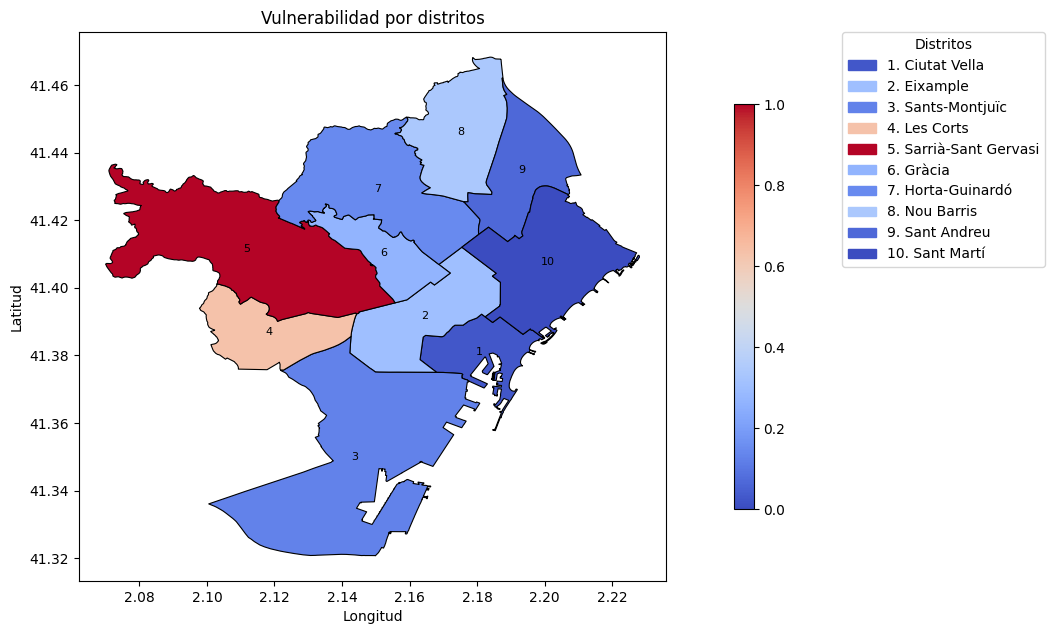

In [8]:
generar_mapa('../../../1-DATOS/2-DATOS PROCESADOS/GEOPORTAL/districtes.geojson', vulnerabilidad, metric_column='metrica', save_path='vulnerabilidad_prueba.png')

In [9]:
nombres = ['Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts','Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó', 'Nou Barris', 'Sant Andreu', 'Sant Martí']

pred_vulnerabilidad = pred_vulnerabilidad.reset_index()
pred_vulnerabilidad.columns = ['distrito', 'metrica']
pred_vulnerabilidad['distrito'] = pd.Categorical(pred_vulnerabilidad['distrito'], categories=nombres, ordered=True)
pred_vulnerabilidad = pred_vulnerabilidad.sort_values('distrito')

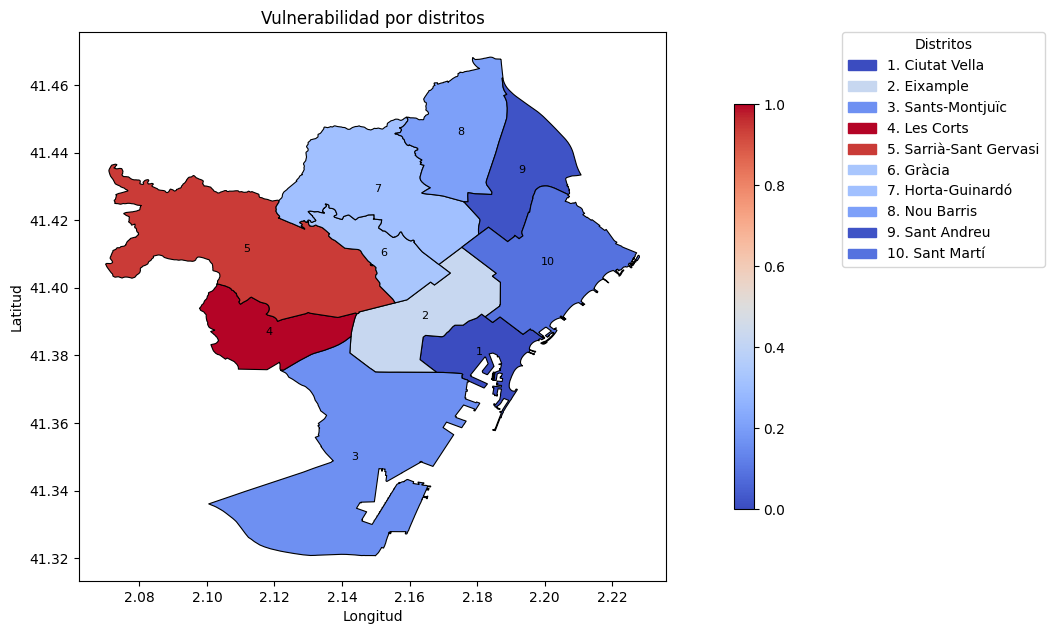

In [10]:
generar_mapa('../../../1-DATOS/2-DATOS PROCESADOS/GEOPORTAL/districtes.geojson', pred_vulnerabilidad, metric_column='metrica', save_path='vulnerabilidad_prueba.png')